In [10]:
import warnings
warnings.filterwarnings('ignore')

from sigpyproc.readers import FilReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import dates
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval
from scipy.optimize import fsolve
from tqdm import tqdm

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

path = '/home/mnedal/data/ilofar'

In [2]:
date = '2025-03-26'
part = '1'
stokes = 'I'

In [5]:
# filename = f'{path}/Sun357_{date}_typeII.fil'
filename = f'{path}/Sun357_{date}_typeII_{part}.fil'

a = FilReader(filename) # header
header = a.header.to_dict()

In [6]:
header

{'filename': '/home/mnedal/data/ilofar/Sun357_2025-03-26_typeII_1.fil',
 'data_type': 'filterbank',
 'nchans': 488,
 'foff': -0.1953125,
 'fch1': 200.0,
 'nbits': 32,
 'tsamp': 0.00131072,
 'tstart': 60760.354861113,
 'nsamples': 2700805,
 'nifs': 1,
 'coord': <SkyCoord (ICRS): (ra, dec) in deg
     (0., 0.)>,
 'azimuth': <Angle 44.78141737 deg>,
 'zenith': <Angle 39.73605795 deg>,
 'telescope': 'MeerKAT',
 'backend': 'FAKE',
 'source': 'Sun357',
 'frame': 'topocentric',
 'ibeam': 0,
 'nbeams': 0,
 'dm': 0,
 'period': 0,
 'accel': 0,
 'signed': False,
 'rawdatafile': 'unknown',
 'stream_info': {'entries': [{'filename': '/home/mnedal/data/ilofar/Sun357_2025-03-26_typeII_1.fil',
    'hdrlen': 347,
    'datalen': 5271971360,
    'nsamples': 2700805,
    'tstart': 60760.354861113,
    'tsamp': 0.00131072}]},
 'basename': 'Sun357_2025-03-26_typeII_1',
 'extension': '.fil',
 'telescope_id': 64,
 'machine_id': 0,
 'bandwidth': 95.3125,
 'ftop': 200.09765625,
 'fbottom': 104.78515625,
 'fcente

In [13]:
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
n_samples = a.header.nsamples
print(tstart_obs_str, n_samples, sep='\n')

2025-03-26 08:31:00.000
2700805


In [14]:
data = a.read_block(start=0, nsamps=n_samples)

In [15]:
print(data.shape)

(488, 2700805)


In [16]:
# making time axis
tstart = Time(data.header.tstart, format='mjd')                    # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data.shape[1])*data.header.tsamp*u.s) # making the time array for realta time resolution
print(len(tarray), tarray[0].iso, tarray[-1].iso, sep='\n')

2700805
2025-03-26 08:31:00.000
2025-03-26 09:29:59.998


In [17]:
dt = datetime.strptime(tarray[1].iso, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(tarray[0].iso, '%Y-%m-%d %H:%M:%S.%f')
print('Time cadence:', dt.total_seconds()*1000, 'ms.')

Time cadence: 1.0 ms.


In [18]:
# Converting the array to datetime object --> expand the for-loop and use tqdm since this step takes a long time!
# Tarray = [datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f') for t in tarray]
        
Tarray = []
with tqdm(total=len(tarray), desc='Converting time array to datetime object') as pbar:
    for t in tarray:
        tmp_var = datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f')
        Tarray.append(tmp_var)
        pbar.update(1)

print(Tarray[0], Tarray[-1], sep='\n')

Converting time array to datetime object: 100%|██████████████████████████| 2700805/2700805 [10:00<00:00, 4497.26it/s]

2025-03-26 08:31:00
2025-03-26 09:29:59.998000


In [19]:
# export the frequency axis
freqs = data.header.chan_freqs
print(freqs[0], freqs[-1], sep='\n')

200.0
104.8828125


In [20]:
def freq_axis(freqs):
    """
    Introduce gaps in the frequency axis of I-LOFAR REALTA data.
    """
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88] = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:] = freqs[289:]
    
    return new_freq

In [21]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

In [22]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

df_mode3 = pd.DataFrame(data=data2[404:].T, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, columns=freq_mode7[::-1])

In [23]:
print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(2700805, 199)
(2700805, 200)
(2700805, 88)


In [24]:
# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(Tarray)
df_mode5.index = pd.to_datetime(Tarray)
df_mode7.index = pd.to_datetime(Tarray)

In [25]:
# Save the dataframes as a pickle files
df_mode3.to_pickle(f'{path}/df_mode3_realta_{date}_stokes{stokes}_part{part}.pkl')
df_mode5.to_pickle(f'{path}/df_mode5_realta_{date}_stokes{stokes}_part{part}.pkl')
df_mode7.to_pickle(f'{path}/df_mode7_realta_{date}_stokes{stokes}_part{part}.pkl')

---

## Load the dataframes from the pickle files

In [26]:
df_mode3 = pd.read_pickle(f'{path}/df_mode3_realta_{date}_stokes{stokes}_part{part}.pkl')
df_mode5 = pd.read_pickle(f'{path}/df_mode5_realta_{date}_stokes{stokes}_part{part}.pkl')
df_mode7 = pd.read_pickle(f'{path}/df_mode7_realta_{date}_stokes{stokes}_part{part}.pkl')

In [27]:
time_mode3 = df_mode3.index
time_mode5 = df_mode5.index
time_mode7 = df_mode7.index

freq_mode3 = df_mode3.columns
freq_mode5 = df_mode5.columns
freq_mode7 = df_mode7.columns

In [28]:
# df_mode3.head(3)

In [29]:
# df_mode5.head(3)

In [30]:
# df_mode7.head(3)

## Quick tmp inspect

In [32]:
# Downsample to 1-second resolution for faster testing and visualization
df_mode3_1s = df_mode3.resample('1S').mean()
df_mode5_1s = df_mode5.resample('1S').mean()
df_mode7_1s = df_mode7.resample('1S').mean()

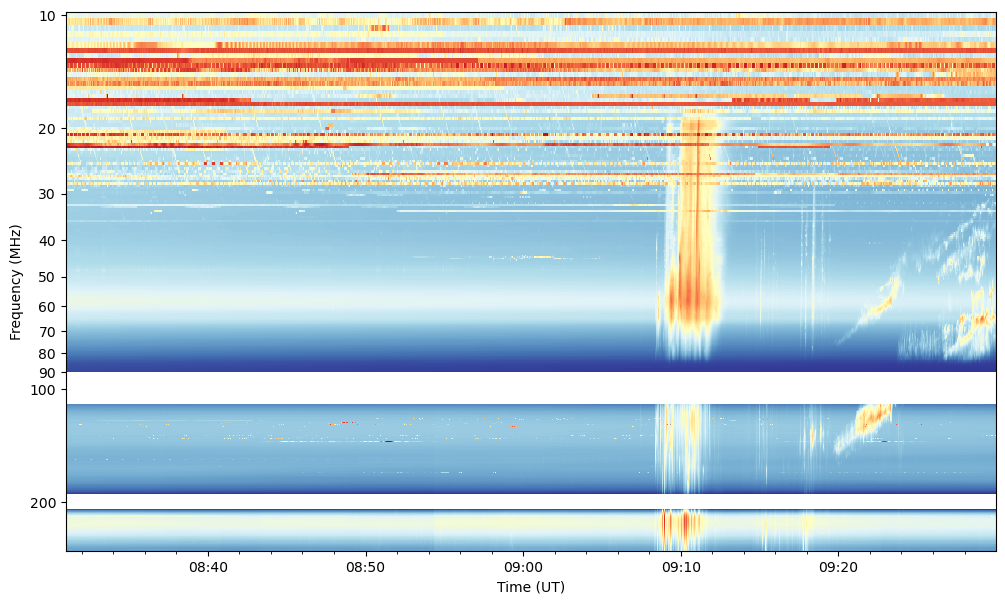

In [33]:
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_1s.index, df_mode3_1s.columns, df_mode3_1s.values.T, cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_1s.index, df_mode5_1s.columns, df_mode5_1s.values.T, cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_1s.index, df_mode7_1s.columns, df_mode7_1s.values.T, cmap='RdYlBu_r')
ax.set_yscale('log')
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [88]:
from astropy.io import fits

MODE  = 7
TIMES = [t.isoformat() for t in df_mode7.index]
FREQS = df_mode7.columns.values
ARRAY = df_mode7.to_numpy()

# Create a FITS header from metadata dictionary
metadata = {
    'TELESCOP': 'I-LOFAR',
    'MODE': MODE,
    'FREQ_UNIT': 'MHz',
    'TIME_UNIT': 'UTC',
    'START_FREQ': FREQS[0],
    'END_FREQ': FREQS[-1],
    'START_TIME': TIMES[0],
    'END_TIME': TIMES[-1]
}

HEADER = fits.Header(metadata)

# Make a PrimaryHDU (Primary Data Unit)
hdu = fits.PrimaryHDU(ARRAY, header=HEADER)

# Save the FITS file
hdu.writeto(f'{path}/df_mode{MODE}_realta_{date}_stokes{stokes}.fits', overwrite=True)

In [85]:
# Export TIMES and FREQS arrays as pickle files
import pickle

MODE  = 7
TIMES = df_mode7.index.to_series()
FREQS = df_mode7.columns.values

with open(f'{path}/mode{MODE}_{date}_stokes{stokes}_TIMES.pkl', 'wb') as f:
    pickle.dump(TIMES, f)

with open(f'{path}/mode{MODE}_{date}_stokes{stokes}_FREQS.pkl', 'wb') as f:
    pickle.dump(FREQS, f)

In [56]:
df_mode3.index.to_pydatetime()

array([datetime.datetime(2025, 3, 26, 8, 31),
       datetime.datetime(2025, 3, 26, 8, 31, 0, 1000),
       datetime.datetime(2025, 3, 26, 8, 31, 0, 3000), ...,
       datetime.datetime(2025, 3, 26, 9, 29, 59, 995000),
       datetime.datetime(2025, 3, 26, 9, 29, 59, 997000),
       datetime.datetime(2025, 3, 26, 9, 29, 59, 998000)], dtype=object)

In [61]:
meta = {
        'observatory': 'I-LOFAR',
        'instrument': 'mode3',
        'detector': '',
        'freqs': df_mode3.columns.values,
        'times': df_mode3.index.to_series(),
        'start_time': df_mode3.index.to_series()[0],
        'end_time': df_mode3.index.to_series()[-1]
    }

mode3_spectrum = Spectrogram(df_mode3.values, meta)

AttributeError: 'Series' object has no attribute 'datetime'

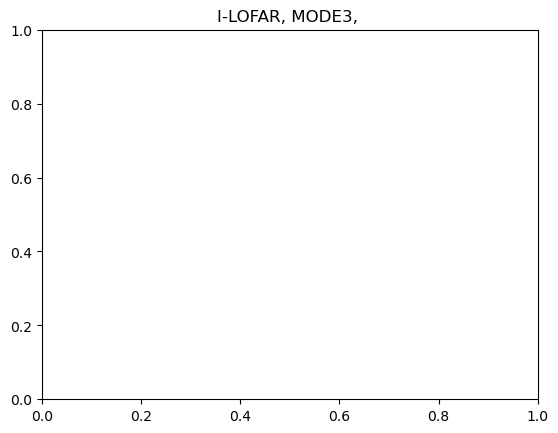

In [62]:
mode3_spectrum.plot()

In [ ]:
# Combine the 3 modes in a single spectrum






In [ ]:
# Convert the data to spectrogram and export as .fit file
from radiospectra.spectrogram import Spectrogram

ilofar_spectrum = Spectrogram(psd_sfu.T, meta)

### Inspect the time and frequency resolution

In [36]:
dt = df_mode3.index[1] - df_mode3.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode3.columns[0] - df_mode3.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.001 s.
Frequency cadence: 0.404 MHz.


In [37]:
dt = df_mode5.index[1] - df_mode5.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode5.columns[0] - df_mode5.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.001 s.
Frequency cadence: 0.402 MHz.


In [38]:
dt = df_mode7.index[1] - df_mode7.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode7.columns[0] - df_mode7.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.001 s.
Frequency cadence: 0.690 MHz.


In [39]:
# dt = [df_mode3.index[i+1] - df_mode3.index[i] for i in range(len(df_mode3.index))]

In [40]:
# i = 1000
# df_mode3.index[i+1] - df_mode3.index[i]

In [41]:
# i = 1000
# df_mode7.index[i+1] - df_mode7.index[i]

In [42]:
# i = 50
# df_mode7.columns[i] - df_mode7.columns[i+1]

In [93]:
# remove the const background
mode3_new = df_mode3.values - np.tile(np.nanmean(df_mode3.values,0), (df_mode3.values.shape[0],1))
mode5_new = df_mode5.values - np.tile(np.nanmean(df_mode5.values,0), (df_mode5.values.shape[0],1))
mode7_new = df_mode7.values - np.tile(np.nanmean(df_mode7.values,0), (df_mode7.values.shape[0],1))

In [94]:
# construct dataframes again
df_mode3_new = pd.DataFrame(data=mode3_new, columns=freq_mode3)
df_mode5_new = pd.DataFrame(data=mode5_new, columns=freq_mode5)
df_mode7_new = pd.DataFrame(data=mode7_new, columns=freq_mode7)

# set the time column as the dataframe index
df_mode3_new.index = pd.to_datetime(time_mode3)
df_mode5_new.index = pd.to_datetime(time_mode5)
df_mode7_new.index = pd.to_datetime(time_mode7)

In [95]:
df_mode3_new.head(3)

,90.000000,89.595960,89.191919,88.787879,88.383838,87.979798,87.575758,87.171717,86.767677,86.363636,...,13.636364,13.232323,12.828283,12.424242,12.020202,11.616162,11.212121,10.808081,10.404040,10.000000
2025-03-26 09:31:00.001,0.027710,0.040143,0.032216,0.016395,0.024730,0.028199,0.031014,0.027557,0.065254,0.047455,...,-0.690760,0.337192,0.200669,0.158381,0.081687,0.241881,0.359399,0.318216,0.249518,0.323551
2025-03-26 09:31:00.002,0.033620,0.022835,0.018437,0.022175,0.063003,0.026117,0.011820,0.031043,0.031563,0.008263,...,-0.606237,0.406261,0.463494,0.268162,0.353616,0.272997,0.397107,0.541364,0.265678,0.337226
2025-03-26 09:31:00.004,0.017681,0.041735,0.025624,0.047509,0.064813,0.023520,0.031648,0.057897,0.027117,-0.007946,...,-0.608352,0.368820,0.669116,0.245096,-0.023248,0.282677,0.415964,0.499541,0.323057,0.477161


In [96]:
# Slice the DataFrame between start_date and end_date
# start_date = '2024-05-14 17:28:00'
start_date = df_mode3_new.index[0]
# end_date   = '2024-05-14 17:00:00'

# df_mode3_slice = df_mode3.loc[start_date:end_date]
# df_mode5_slice = df_mode5.loc[start_date:end_date]
# df_mode7_slice = df_mode7.loc[start_date:end_date]

df_mode3_new = df_mode3_new.loc[start_date:]
df_mode5_new = df_mode5_new.loc[start_date:]
df_mode7_new = df_mode7_new.loc[start_date:]

In [97]:
del df_mode3
del df_mode5
del df_mode7

del mode3_new
del mode5_new
del mode7_new

### Plot the full dynamic spectrum at max. resolution

In [98]:
# min_range = -0.5
# max_range = 2

# fig = plt.figure(figsize=[12,7])
# ax = fig.add_subplot(111)
# ax.pcolormesh(df_mode3_new.index, df_mode3_new.columns, df_mode3_new.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(df_mode5_new.index, df_mode5_new.columns, df_mode5_new.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(df_mode7_new.index, df_mode7_new.columns, df_mode7_new.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.set_yscale('log')

# # Define the custom ticks
# custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
# ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_ylim(ax.get_ylim()[::-1])
# plt.show()

In [99]:
# Downsample to 1-second resolution for faster testing and visualization
df_mode3_1s = df_mode3_new.resample('1S').mean()
df_mode5_1s = df_mode5_new.resample('1S').mean()
df_mode7_1s = df_mode7_new.resample('1S').mean()

In [100]:
df_mode3_1s.head()

,90.000000,89.595960,89.191919,88.787879,88.383838,87.979798,87.575758,87.171717,86.767677,86.363636,...,13.636364,13.232323,12.828283,12.424242,12.020202,11.616162,11.212121,10.808081,10.404040,10.000000
2025-03-26 09:31:00,0.027747,0.028602,0.027173,0.029959,0.028676,0.026629,0.028547,0.029904,0.030097,0.031159,...,-0.170503,0.309621,0.328395,0.251663,0.207868,0.279321,0.203169,0.309096,0.325154,0.407597
2025-03-26 09:31:01,0.025636,0.030838,0.025668,0.030299,0.028467,0.026171,0.027674,0.029040,0.030668,0.031523,...,0.362277,0.307564,0.350681,0.296702,0.242906,0.319701,0.239634,0.352522,0.304143,0.335657
2025-03-26 09:31:02,0.027211,0.029163,0.026875,0.030102,0.029419,0.027149,0.027619,0.028919,0.029538,0.031627,...,0.382035,0.326281,0.355147,0.314722,0.307917,0.322932,0.441744,0.274668,0.305618,0.362052
2025-03-26 09:31:03,0.026360,0.029645,0.025686,0.029974,0.027445,0.026061,0.027600,0.029411,0.029860,0.030759,...,0.471103,0.288310,0.270675,0.305026,0.345541,0.289330,0.277344,0.246196,0.293172,0.268743
2025-03-26 09:31:04,0.027225,0.030182,0.025402,0.028437,0.029234,0.025410,0.027402,0.029353,0.030421,0.031681,...,0.433367,0.262884,0.208907,0.310109,0.363851,0.282350,0.332208,0.321558,0.285547,0.226625


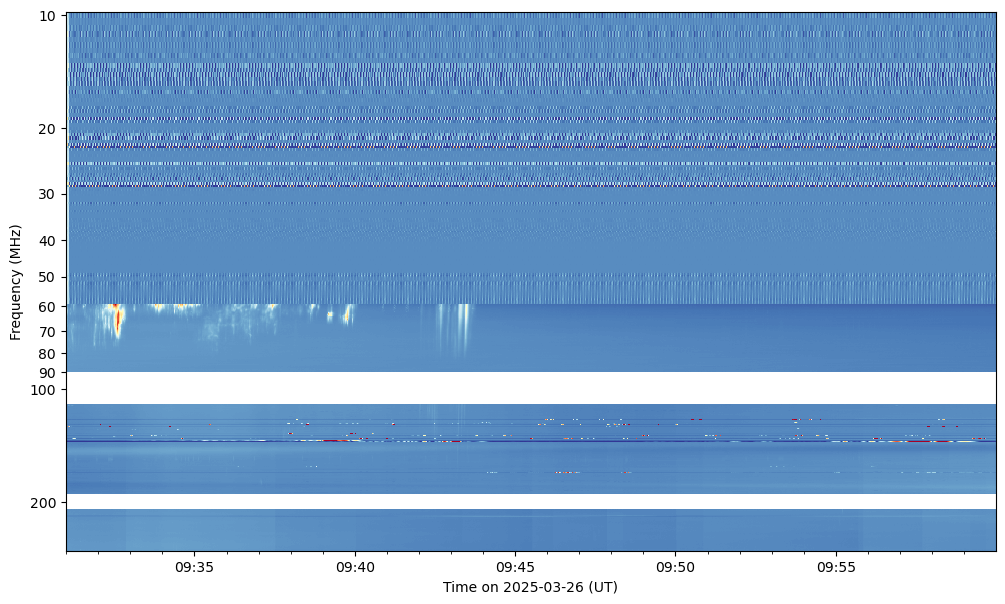

In [101]:
min_range = -0.2
max_range = 1.2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_1s.index, df_mode3_1s.columns, df_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_1s.index, df_mode5_1s.columns, df_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_1s.index, df_mode7_1s.columns, df_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel(f'Time on {start_date.date()} (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

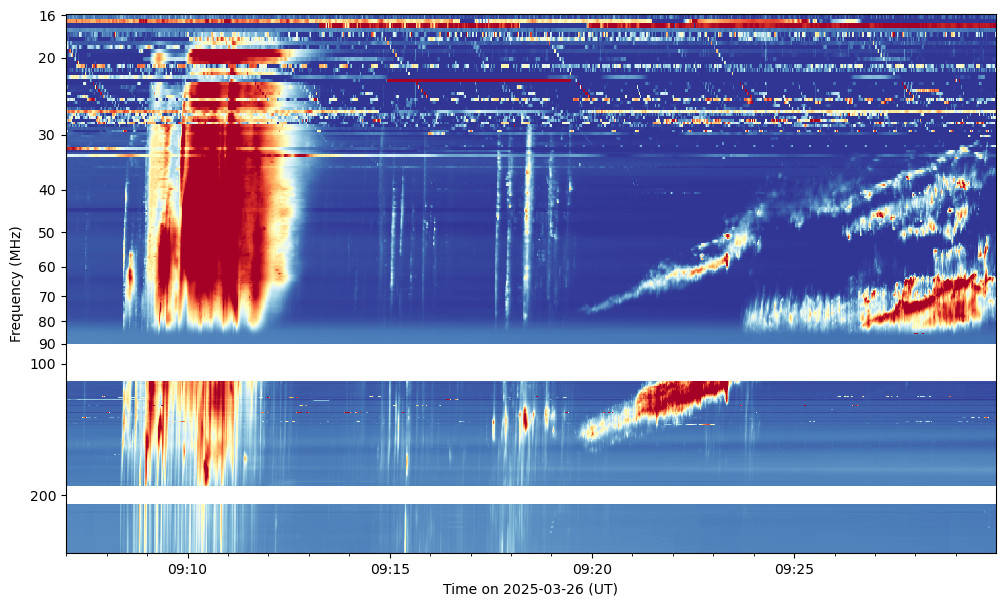

In [62]:
# Take a slice
start_date = '2025-03-26 09:07'
end_date   = df_mode3_1s.index[-1]

freq_min = 16
freq_max = 270

# Convert column names to numeric values (if they are strings)
df_mode3_slice = df_mode3_1s.loc[start_date:end_date, 
                                 df_mode3_1s.columns[(df_mode3_1s.columns.astype(float) >= freq_min) & 
                                                     (df_mode3_1s.columns.astype(float) <= freq_max)]]

df_mode5_slice = df_mode5_1s.loc[start_date:end_date, 
                                 df_mode5_1s.columns[(df_mode5_1s.columns.astype(float) >= freq_min) & 
                                                     (df_mode5_1s.columns.astype(float) <= freq_max)]]

df_mode7_slice = df_mode7_1s.loc[start_date:end_date, 
                                 df_mode7_1s.columns[(df_mode7_1s.columns.astype(float) >= freq_min) & 
                                                     (df_mode7_1s.columns.astype(float) <= freq_max)]]

# Plot the new slice
min_range = -0.2
max_range = 1.2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_slice.index, df_mode3_slice.columns, df_mode3_slice.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_slice.index, df_mode5_slice.columns, df_mode5_slice.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_slice.index, df_mode7_slice.columns, df_mode7_slice.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
# custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200] # Original
custom_ticks = [16, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel(f'Time on {date} (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

### Pick the type II bursts

In [ ]:
typeII_1_mode3 = df_mode3_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode5 = df_mode5_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode7 = df_mode7_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']

typeII_2_mode3 = df_mode3_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode5 = df_mode5_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode7 = df_mode7_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']

typeII_3_mode3 = df_mode3_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode5 = df_mode5_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode7 = df_mode7_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']

In [ ]:
del df_mode3_new
del df_mode5_new
del df_mode7_new

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3.index, typeII_1_mode3.columns, typeII_1_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5.index, typeII_1_mode5.columns, typeII_1_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7.index, typeII_1_mode7.columns, typeII_1_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3.index, typeII_2_mode3.columns, typeII_2_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5.index, typeII_2_mode5.columns, typeII_2_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7.index, typeII_2_mode7.columns, typeII_2_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

In [ ]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3.index, typeII_3_mode3.columns, typeII_3_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5.index, typeII_3_mode5.columns, typeII_3_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7.index, typeII_3_mode7.columns, typeII_3_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

## Clicking ...

In [ ]:
import matplotlib
matplotlib.use('nbAgg')

## Applying Bezier curve method

In [ ]:
time_cadence = abs(np.nanmedian(np.diff(combined_typeII_df1_1s.index)))
time_cadence.item()/

In [ ]:
time_cadence

## Auto-tracing of type IIs

In [ ]:
def draw_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
    """
    Draw a Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    A = np.array([x2, y2])
    B = np.array(control)
    C = np.array([x1, y1])

    A = A.reshape(2,1)
    B = B.reshape(2,1)
    C = C.reshape(2,1)
    
    t = np.arange(0, 1, 0.02).reshape(1,-1)
    
    # length = len(df.index)
    # t = np.linspace(0, 1, length).reshape(1,-1)
    # t = np.arange(0, length, 1).reshape(1,-1)
    
    P0 = A * t + (1 - t) * B
    P1 = B * t + (1 - t) * C
    Pfinal = P0 * t + (1 - t) * P1

    return Pfinal

def extract_bezier_values(df, x1, y1, x2, y2, control):
    """
    Extract the values of a Bezier curve at the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1])
    """
    array = df.values.T
    Pfinal = draw_bezier(x1, y1, x2, y2, control)
    x_coords = np.round(Pfinal[0, :]).astype(int)
    y_coords = np.round(Pfinal[1, :]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords

In [ ]:
# print(typeII_1_mode3_1s.columns[0], typeII_1_mode3_1s.columns[-1])
# print(typeII_1_mode5_1s.columns[0], typeII_1_mode5_1s.columns[-1])
# print(typeII_1_mode7_1s.columns[0], typeII_1_mode7_1s.columns[-1])

In [ ]:
# print(typeII_1_mode3_1s.columns[1] - typeII_1_mode3_1s.columns[0])
# print(typeII_1_mode5_1s.columns[1] - typeII_1_mode5_1s.columns[0])
# print(typeII_1_mode7_1s.columns[1] - typeII_1_mode7_1s.columns[0])

In [ ]:
def combine_ilofar_modes(mode3, mode5, mode7):
    """
    Combine data from the three observation modes of the I-LOFAR station into a single DataFrame.
    
    This function takes three pandas DataFrames,
    each representing an observation mode: Mode 3, Mode 5, and Mode 7.
    Each DataFrame contains frequency observations with datetime indices.
    The function combines these DataFrames into a single DataFrame,
    filling in frequency gaps between the modes with empty columns.

    Parameters:
    -----------
    mode3 : pandas.DataFrame
        DataFrame for Mode 3 observations, with datetime index and frequency columns.
    mode5 : pandas.DataFrame
        DataFrame for Mode 5 observations, with datetime index and frequency columns.
    mode7 : pandas.DataFrame
        DataFrame for Mode 7 observations, with datetime index and frequency columns.

    Returns:
    --------
    pandas.DataFrame
        A combined DataFrame containing all observations from Mode 3, Mode 5, and Mode 7, with empty columns
        filling the frequency gaps. The columns are sorted numerically.

    Notes:
    ------
    - The function calculates the frequency cadence for each mode by taking the absolute median difference 
      of the mode's column frequencies.
    - It then generates empty DataFrames to fill the frequency gaps between the observation modes.
    - Finally, it concatenates all DataFrames along the columns axis, converts the index to numerical dates, 
      and sorts the columns numerically.

    Example:
    --------
    >>> combined_df = combine_ilofar_modes(mode3_df, mode5_df, mode7_df)
    >>> print(combined_df.head())
    """
    mode3_freq_cadence = abs(np.nanmedian(np.diff(mode3.columns)))
    mode5_freq_cadence = abs(np.nanmedian(np.diff(mode5.columns)))
    mode7_freq_cadence = abs(np.nanmedian(np.diff(mode7.columns)))
    
    gap1_freqs = np.arange(90+mode3_freq_cadence, 110+mode3_freq_cadence, mode3_freq_cadence)
    df_gap1    = pd.DataFrame(index=mode3.index, columns=gap1_freqs)
    
    gap2_freqs = np.arange(190+mode5_freq_cadence, 210+mode5_freq_cadence, mode5_freq_cadence)
    df_gap2    = pd.DataFrame(index=mode3.index, columns=gap2_freqs)
    
    # Concatenate along columns axis
    combined_df       = pd.concat([mode3, df_gap1, mode5, df_gap2, mode7], axis=1)
    combined_df.index = mdates.date2num(combined_df.index)
    
    # Sort columns numerically
    combined_df = combined_df.reindex(sorted(combined_df.columns.astype('float')), axis=1).astype('float64')
    
    return combined_df

In [ ]:
combined_typeII_df1 = combine_ilofar_modes(typeII_1_mode3, typeII_1_mode5, typeII_1_mode7)
combined_typeII_df2 = combine_ilofar_modes(typeII_2_mode3, typeII_2_mode5, typeII_2_mode7)
combined_typeII_df3 = combine_ilofar_modes(typeII_3_mode3, typeII_3_mode5, typeII_3_mode7)

In [ ]:
combined_typeII_df1.shape, combined_typeII_df2.shape, combined_typeII_df3.shape

In [ ]:
# mode3_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode3_1s.columns)))
# mode5_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode5_1s.columns)))
# mode7_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode7_1s.columns)))

# print(mode3_freq_cadence)
# print(mode5_freq_cadence)
# print(mode7_freq_cadence)

In [ ]:
# gap1_freqs = np.arange(90+mode3_freq_cadence, 110+mode3_freq_cadence, mode3_freq_cadence)
# df_gap1 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap1_freqs)

# gap2_freqs = np.arange(190+mode5_freq_cadence, 210+mode5_freq_cadence, mode5_freq_cadence)
# df_gap2 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap2_freqs)

In [ ]:
# # Concatenate along columns axis
# combined_df = pd.concat([typeII_1_mode3_1s, df_gap1, typeII_1_mode5_1s, df_gap2, typeII_1_mode7_1s], axis=1)
# combined_df.index = mdates.date2num(combined_df.index)

# # Sort columns numerically
# combined_df = combined_df.reindex(sorted(combined_df.columns.astype('float')), axis=1).astype('float64')

In [ ]:
min_range = -0.5
max_range = 3

# Plot the spectrum
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(combined_typeII_df1.index, combined_typeII_df1.columns, combined_typeII_df1.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

## Downsample the spectra to 1-second resolution

In [ ]:
# converts the float index to a DatetimeIndex
combined_typeII_df1.index = pd.to_datetime(combined_typeII_df1.index, origin='unix', unit='D')
combined_typeII_df2.index = pd.to_datetime(combined_typeII_df2.index, origin='unix', unit='D')
combined_typeII_df3.index = pd.to_datetime(combined_typeII_df3.index, origin='unix', unit='D')

# downsampling the data to 1-s resolution for faster testing and visualization
combined_typeII_df1_1s = combined_typeII_df1.resample('1S').mean()
combined_typeII_df2_1s = combined_typeII_df2.resample('1S').mean()
combined_typeII_df3_1s = combined_typeII_df3.resample('1S').mean()

In [ ]:
psudo_time = np.arange(len(combined_typeII_df1_1s.index))

# Define start and end points and control point for the Bézier curve
x1, y1 = 42, 165
x2, y2 = 210, 120
control = [110, 125]

# Plot the spectrum and the Bezier curve
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, combined_typeII_df1_1s.columns, combined_typeII_df1_1s.values.T,
              vmin=-0.5, vmax=3, cmap='RdYlBu_r')
ax.set_yscale('log')

# Extract values along the Bézier curve
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, x1, y1, x2, y2, control)
ax.plot(x_coords, y_coords, 'ko-', linewidth=2)

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time step')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

# print(f'intensity values: {bezier_values}\n')
print(f't_coords: {x_coords}\n')
print(f'f_coords: {y_coords}')

In [ ]:
def has_duplicates(lst):
    return len(lst) != len(set(lst))

has_duplicates(x_coords), has_duplicates(y_coords)

In [ ]:
plt.figure(figsize=[15,7])
plt.scatter(x_coords, y_coords)

In [ ]:
# Test draw Bezier curve
x1, y1 = 10, 40
x2, y2 = 20, 80

# Plot the Bezier curves with different control points
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(131)
control_point = [30, 50]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

ax = fig.add_subplot(132)
control_point = [15, 30]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

ax = fig.add_subplot(133)
control_point = [10, 60]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

plt.show()

In [ ]:
Pfinal.shape

In [ ]:
### Multiple bezier curves
psudo_time = np.arange(len(combined_typeII_df1_1s.index))

# Plot the spectrum and the Bezier curve
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, combined_typeII_df1_1s.columns, combined_typeII_df1_1s.values.T,
              vmin=-0.5, vmax=3, cmap='RdYlBu_r')
ax.set_yscale('log')

## Extract values along the Bézier curve
curves_dict = {}

# Harmonic
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 140, 215, 98, [90, 100])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb1'] = x_coords
curves_dict['freq_h_lfb1'] = y_coords
curves_dict['flux_h_lfb1'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 148, 215, 102, [90, 105])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 2 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb2'] = x_coords
curves_dict['freq_h_lfb2'] = y_coords
curves_dict['flux_h_lfb2'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 158, 215, 108, [90, 110])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 3 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb3'] = x_coords
curves_dict['freq_h_lfb3'] = y_coords
curves_dict['flux_h_lfb3'] = bezier_values


bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 165, 215, 120, [100, 125])
ax.plot(x_coords, y_coords, 'o-', c='k', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb1'] = x_coords
curves_dict['freq_h_ufb1'] = y_coords
curves_dict['flux_h_ufb1'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 185, 215, 128, [100, 135])
ax.plot(x_coords, y_coords, 'o-', c='black', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 2 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb2'] = x_coords
curves_dict['freq_h_ufb2'] = y_coords
curves_dict['flux_h_ufb2'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 215, 215, 136, [100, 145])
ax.plot(x_coords, y_coords, 'o-', c='black', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 3 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb3'] = x_coords
curves_dict['freq_h_ufb3'] = y_coords
curves_dict['flux_h_ufb3'] = bezier_values


# Fundamental
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 77, 215, 45, [100, 57])
ax.plot(x_coords, y_coords, 'o-', c='crimson', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 LFB', color='crimson', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_f_lfb3'] = x_coords
curves_dict['freq_f_lfb3'] = y_coords
curves_dict['flux_f_lfb3'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 88, 215, 65, [100, 75])
ax.plot(x_coords, y_coords, 'o-', c='purple', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 UFB', color='purple', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_f_ufb3'] = x_coords
curves_dict['freq_f_ufb3'] = y_coords
curves_dict['flux_f_ufb3'] = bezier_values

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time step')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

In [ ]:
curves_dict

In [ ]:
# min_range = -0.5
# max_range = 3

# ## Define start and end points and control point for the Bézier curve

# # Given timestamp to find the nearest index
# given_timestamp_x1 = pd.Timestamp('2024-05-14 17:30:40')
# given_timestamp_x2 = pd.Timestamp('2024-05-14 17:33:30')

# # Find the nearest index
# nearest_index_x1 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x1)
# nearest_index_x2 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x2)

# x1 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x1])
# x2 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x2])

# # Given number to find the nearest index
# given_freq_y1 = 200
# given_freq_y2 = 120

# # Calculate differences
# differences1 = np.abs(typeII_1_mode3_1s.columns - given_freq_y1)
# differences2 = np.abs(typeII_1_mode3_1s.columns - given_freq_y2)

# # Find the nearest index
# nearest_index_y1 = differences1.argmin()
# nearest_index_y2 = differences2.argmin()

# y1 = typeII_1_mode3_1s.columns[nearest_index_y1]
# y2 = typeII_1_mode3_1s.columns[nearest_index_y2]

# control = [0, 1]

# # Extract values along the Bézier curve
# bezier_values, x_coords, y_coords = extract_bezier_values(typeII_1_mode5_1s.values.T, x1, y1, x2, y2, control)


# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')

# # plt.plot(x_coords, y_coords, 'ko--', linewidth=2)

# ax.set_yscale('log')

# # Define the custom ticks
# custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
# ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
# plt.show()

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)

# List to store coordinates
typeII_1_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_1_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:
df_typeII_1_f_t = pd.DataFrame(typeII_1_f_t_points, columns=['time','frequency'])
df_typeII_1_f_t.head()

In [ ]:
def freq_to_n(fpe):
    """
    Calculate electron density [cm-3] from plasma frequency [Hz].
    """
    ne = (fpe / (8.89*10**3))**2
    return ne


def newkirk_h(r):
    """
    Newkirk electron-density model.
    fold: is a multiplicative factor to change the density scaling.
    """
    fold = 2.5
    model = fold*4.2e4*10**(4.32/r)
    return model


def invert_newkirk_h(ne):
    """
    Invert the Newkirk electron-density model to find the radial distance
    for a given electron density.
    """
    def equation(r):
        # Define the equation for which we need to find the root.
        # It returns the difference between the model's density and the given density.
        return newkirk_h(r) - ne
    
    # Initial guess for the radial distance can be set to a reasonable value.
    r_guess = 1.0
    
    # Use fsolve to find the root of the equation, which is the radial distance r
    # that makes the equation zero.
    r_solution, = fsolve(equation, r_guess)
    return r_solution

In [ ]:
# Convert frequencies to electron densities
ne_typeII_1 = freq_to_n(df_typeII_1_f_t['frequency'].values*10**6)

In [ ]:
ne_typeII_1

In [ ]:
# Convert electron densities to radial distances
r_typeII_1 = [invert_newkirk_h(ne) for ne in ne_typeII_1]

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)

# List to store coordinates
typeII_2_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_2_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:
df_typeII_2_f_t = pd.DataFrame(typeII_2_f_t_points, columns=['time','frequency'])
df_typeII_2_f_t.head()

In [ ]:
# Convert frequencies to electron densities
ne_typeII_2 = freq_to_n(df_typeII_2_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_2 = [invert_newkirk_h(ne) for ne in ne_typeII_2]

In [ ]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)

# List to store coordinates
typeII_3_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_3_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:
df_typeII_3_f_t = pd.DataFrame(typeII_3_f_t_points, columns=['time','frequency'])
df_typeII_3_f_t.head()

In [ ]:
# Convert frequencies to electron densities
ne_typeII_3 = freq_to_n(df_typeII_3_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_3 = [invert_newkirk_h(ne) for ne in ne_typeII_3]

In [ ]:
# Ensure all arrays are converted to lists
data = {
    'time_typeII_1': df_typeII_1_f_t['time'].tolist(),
    'freq_typeII_1': df_typeII_1_f_t['frequency'].tolist(),
    'ne_typeII_1': list(ne_typeII_1),
    'r_typeII_1': list(r_typeII_1),
    
    'time_typeII_2': df_typeII_2_f_t['time'].tolist(),
    'freq_typeII_2': df_typeII_2_f_t['frequency'].tolist(),
    'ne_typeII_2': list(ne_typeII_2),
    'r_typeII_2': list(r_typeII_2),
    
    'time_typeII_3': df_typeII_3_f_t['time'].tolist(),
    'freq_typeII_3': df_typeII_3_f_t['frequency'].tolist(),
    'ne_typeII_3': list(ne_typeII_3),
    'r_typeII_3': list(r_typeII_3)
}

# Find the maximum length
max_len = max(len(lst) for lst in data.values())

# Extend each list with None to the maximum length
for key in data:
    data[key] += [None] * (max_len - len(data[key]))

# Create the DataFrame and save it to a CSV file
df_data = pd.DataFrame(data)
df_data.to_csv('./newkirk_typeIIs.csv', index=False)

In [ ]:
df_data.head()

In [ ]:
list(curves_dict.keys())

In [ ]:
newkirk_radial_distances = {}

In [ ]:
Ne_U = []
rs_U = []
vr_U = []
dfdt_U = []

Ne_L = []
rs_L = []
vr_L = []
dfdt_L = []

# Enter Newkirk model fold number (1, 2, 3 or 4); 1 for quiet Sun, 4 for active regions
fold = 1

# Enter 1 for fundamental, 2 for harmonic
har = 2
lane = 3

if har == 1:
    band = 'f'
elif har == 2:
    band = 'h'

y_coords_U = curves_dict[f'freq_{band}_ufb{lane}']
x_coords_U = combined_typeII_df1_1s.index[curves_dict[f'time_{band}_ufb{lane}']] # extract the corresponding timestamps at those indices
timedelta_U = x_coords_U - x_coords_U[0] # get the time axis in seconds
time_in_seconds_U = np.array(timedelta_U.total_seconds())

y_coords_L = curves_dict[f'freq_{band}_lfb{lane}']
x_coords_L = combined_typeII_df1_1s.index[curves_dict[f'time_{band}_lfb{lane}']] # extract the corresponding timestamps at those indices
timedelta_L = x_coords_L - x_coords_L[0] # get the time axis in seconds
time_in_seconds_L = np.array(timedelta_L.total_seconds())



for i in range(0, len(y_coords_U)):
    ne_U = (y_coords_U[i] / (har * 8.977e-3))**2
    Ne_U.append(ne_U) # electron density
    
    r_newkirk_U = 4.32 / (np.log10(ne_U/(fold * 4.2e4)))
    rs_U.append(r_newkirk_U) # radial distance

    ne_L = (y_coords_L[i] / (har * 8.977e-3))**2
    Ne_L.append(ne_L) # electron density

    r_newkirk_L = 4.32 / (np.log10(ne_L/(fold * 4.2e4)))
    rs_L.append(r_newkirk_L) # radial distance

newkirk_radial_distances[f'rs_{fold}fold_{band}_ufb{lane}'] = rs_U
newkirk_radial_distances[f't_{fold}fold_{band}_ufb{lane}'] = x_coords_U

newkirk_radial_distances[f'rs_{fold}fold_{band}_lfb{lane}'] = rs_L
newkirk_radial_distances[f't_{fold}fold_{band}_lfb{lane}'] = x_coords_L

In [ ]:
plt.figure(figsize=[12,6])

plt.subplot(2,3,1)
plt.plot(time_in_seconds_U, y_coords_U, '-*', color='darkorange', label='UFB')
plt.plot(time_in_seconds_L, y_coords_L, '-*', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Plasma frequency [MHz]')
plt.legend(loc='upper right')

plt.subplot(2,3,2)
dfdt_U = np.abs(np.diff(y_coords_U)/np.diff(time_in_seconds_U))
dfdt_L = np.abs(np.diff(y_coords_L)/np.diff(time_in_seconds_L))
plt.plot(time_in_seconds_U[:-1], dfdt_U, '-^', color='teal', label='UFB')
# plt.plot(x_coords_L[:-1], dfdt_L, '-^', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency Drift [MHz/s]')
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.plot(rs_U, y_coords_U, '-x', color='crimson', label='UFB')
# plt.plot(rs_L, y_coords_L, '-x', color='black', label='LFB')
plt.ylabel('Plasma frequency [MHz]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.plot(rs_U[:-1], dfdt_U, '--o', color='darkorchid', label='UFB')
plt.plot(rs_L[:-1], dfdt_L, '--o', color='black', label='LFB')
plt.ylabel('Frequency Drift [MHz/s]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,6)
vr_U = (np.diff(rs_U)*696340)/np.diff(time_in_seconds_U) # convert height from Rs to km
vr_L = (np.diff(rs_L)*696340)/np.diff(time_in_seconds_L)
plt.plot(time_in_seconds_U[:-1], vr_U, '-.o', color='gold', label='UFB')
plt.plot(time_in_seconds_L[:-1], vr_L, '-.o', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Shock Speed [km/s]')
plt.legend(loc='upper right')

ym_U = np.nanmean(vr_U)
ym_L = np.nanmean(vr_L)
v1_U = ((rs_U[-1] - rs_U[0])*696340)/(time_in_seconds_U[-1] - time_in_seconds_U[0])
v1_L = ((rs_L[-1] - rs_L[0])*696340)/(time_in_seconds_L[-1] - time_in_seconds_L[0])
plt.subplot(2,3,3)
plt.plot(time_in_seconds_U, rs_U, '-o', color='dodgerblue', label=f'UFB\nMean = {ym_U:.2f} km/s\n1st order = {v1_U:.2f} km/s')
plt.plot(time_in_seconds_L, rs_L, '-o', color='black', label=f'LFB\nMean = {ym_L:.2f} km/s\n1st order = {v1_L:.2f} km/s')
plt.xlabel('Time [s]')
plt.ylabel('Height [Rsun]')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_aia171 = pd.read_csv('./jplot_aia_171_CME_No2.csv')
df_aia193 = pd.read_csv('./jplot_aia_193_CME_No2.csv')
df_aia211 = pd.read_csv('./jplot_aia_211_CME_No2.csv')

df_suvi171 = pd.read_csv('./jplot_suvi_171_CME_No2.csv')
df_suvi195 = pd.read_csv('./jplot_suvi_195_CME_No2.csv')
df_suvi284 = pd.read_csv('./jplot_suvi_284_CME_No2.csv')

In [ ]:
def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]


centered_list = generate_centered_list(160, 2, 3)

In [ ]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Reds')
cmap_cme = plt.get_cmap('Blues')

# make 3 evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
colors171_cme = [cmap_cme(i / len(centered_list)) for i in range(1, len(centered_list)+1)]

rsun_aia = 949.556184 # solar radius in arcsec in AIA FOV
rsun_suvi = 949.1129337297962

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_aia171[f'x_{angle}deg'], df_aia171[f'y_{angle}deg']/rsun_aia, 'o-', ms=4, color=colors171_cme[i], label=f'Slit {angle}')

# cmap_radio_ccuddy = plt.get_cmap('Greens')
# colors_radio_ccuddy = [cmap_radio_ccuddy(i / 16) for i in range(1, 16)]
# for i in range(1,15):
#     df = pd.read_csv(f'./ccuddy/burst{i}.csv')
#     x_coords = df.columns.values.astype('float64')
#     y_coords = df.values.reshape(-1)
#     ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio_ccuddy[i], label=f'Type II no.{i}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.03, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from AIA 171 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:16'), right=pd.Timestamp('2024-05-14 17:34'))
plt.show()

In [ ]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Reds')
cmap_cme = plt.get_cmap('Blues')

# make evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
colors193_cme = [cmap_cme(i / len(centered_list)) for i in range(1, len(centered_list)+1)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_aia193[f'x_{angle}deg'], df_aia193[f'y_{angle}deg']/rsun_aia, 'o-', ms=4, color=colors193_cme[i], label=f'Slit {angle}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.03, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from AIA 193 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:16'), right=pd.Timestamp('2024-05-14 17:34'))
plt.show()

In [ ]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Oranges')
cmap_cme = plt.get_cmap('Purples')

# make evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
color_offset = 2
colors195_cme = [cmap_cme(i / (len(centered_list)+color_offset)) for i in range(color_offset, len(centered_list)+color_offset)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_suvi195[f'x_{angle}deg'], df_suvi195[f'y_{angle}deg']/rsun_suvi, 'o-', ms=4, color=colors195_cme[i], label=f'Slit {angle}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.23, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from SUVI 195 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:14'), right=pd.Timestamp('2024-05-14 17:40'))
plt.show()

In [ ]:
list(newkirk_radial_distances.keys())

In [ ]:
band = 'h'
subband = 'u'
lane = 3

cmap_radio = plt.get_cmap('Reds')
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend()
plt.show()

In [ ]:
band = 'h'
subband = 'l'
lane = 3

cmap_radio = plt.get_cmap('Reds')
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend()
plt.show()